# Place preference quantification & heatmap generation code
This is the demo template code for quantifying the place preference as well as generating heatmaps. Basically we're going to run the the video with opencv and manually sort of "label" it by pressing 1 or 2. The latter portion here shows the the heatmap generation example with seaborn's kdeplot function.

In [1]:
#Imports
import numpy as np
from skimage.measure import label, regionprops, find_contours
import skvideo.io
import imageio
import cv2
import operator
import math
import matplotlib.pyplot as plt
%matplotlib inline 
import time
from tqdm import tqdm_notebook as tqdm
import os


print(cv2.__version__)

3.4.3


# Ignore the cell below if you're not Shay

In [27]:
# convert each video to an mp4 cuz who plays with mkv files?
filename = "/home/shayok/Downloads/myAnimal20181129_124437_track.1.h264"
videogen = skvideo.io.vreader(filename)
metadata = skvideo.io.ffprobe(filename)
inputparameters = {"-s":640x480}
outputparameters = {}
reader = skvideo.io.FFmpegReader(filename,
                inputdict=inputparameters,
                outputdict=outputparameters)
print(reader.inputwidth,reader.inputheight,reader.inputframenum)
fps=30
outfile = "/home/shayok/Downloads/myAnimal20181129_124437_track.1.mp4"
writer = imageio.get_writer(outfile, fps=fps)
for i,im in tqdm(enumerate(reader.nextFrame())):
    writer.append_data(im, meta={'fps': fps})
writer.close()

SyntaxError: invalid syntax (<ipython-input-27-762eb3e84a55>, line 5)

# Run me and have flan! (also fun)

In [16]:
# Imports
import numpy as np
from skimage.measure import label, regionprops, find_contours
import imageio
import cv2
import operator
import math
import matplotlib.pyplot as plt
%matplotlib inline 
import time
from tqdm import tqdm_notebook
import os


#File IO
infile = '/media/shayok/3TBData/Data/magreward/EnclosedImplant/Ratterson/pref0.mp4' #CHANGE ME!
reader = imageio.get_reader(infile)
fps = reader.get_meta_data()['fps']
print('input video file length is {} seconds'.format(reader.get_length()/(fps)))
print('input video file has a framerate of {} fps'.format(fps))
# writer = imageio.get_writer('test-out.mp4', fps=fps) #CHANGE ME PER VIDEO!

frameWait = 10 # msec #CHANGE ME!

# just to give a bit of time before the video starts playing
pauseTime = 0.1 # sec
time.sleep(pauseTime)

coil1Frames = []
coil2Frames = []

prevKey = 0
stopAppendingCoil1 = False
stopAppendingCoil2 = False
appendCoil1 = False
appendCoil2 = False

print("Playing video")

#Read in file frame by frame
for i, im in enumerate(tqdm_notebook(reader, desc='Playing back video')):
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    cv2.imshow('im', im)
    #Wait frameWait before moving on to next frame
    k = cv2.waitKey(frameWait) & 0xFF 
    if k == 49: #'1'
        if(prevKey == 49):
            stopAppendingCoil1 = True
            appendCoil1 = False
            prevKey = 0
            print("Stopped appending frames to Coil 1")
        else:
            print("Appending frames to Coil 1")
            stopAppendingCoil1 = False
            appendCoil1 = True
            prevKey = 49
            coil1Frames.append(i)
    elif k == 50: # 2
        if(prevKey == 50):
            stopAppendingCoil2 = True
            appendCoil2 = False
            prevKey = 0
            print("Stopped appending frames to Coil 2")
        else:
            print("Appending frames to Coil 2")
            stopAppendingCoil2 = False
            appendCoil2 = True
            prevKey = 50
            coil2Frames.append(i)
    if appendCoil1:
        coil1Frames.append(i)
    elif appendCoil2:
        coil2Frames.append(i)
        
    if k == 112: #'p'
        print("Video paused for {} seconds".format(pauseTime))
        time.sleep(pauseTime)
        print("Playing video")
    if k == 27: #'ESC' 
        break
    
cv2.destroyAllWindows()

# np.savez('/media/shayok/3TBData/Data/magreward/Butterworth/ContextPreference/6-26-18/offResPos.npz',positions=position.coordinates) #CHANGE ME TOO!

input video file length is inf seconds
input video file has a framerate of 60.0 fps
Playing video


Appending frames to Coil 1
Stopped appending frames to Coil 1
Appending frames to Coil 1
Stopped appending frames to Coil 1
Appending frames to Coil 1
Stopped appending frames to Coil 1
Appending frames to Coil 2
Stopped appending frames to Coil 2
Appending frames to Coil 2
Stopped appending frames to Coil 2


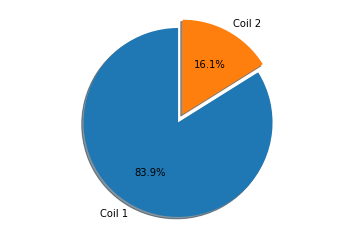

In [17]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Coil 1', 'Coil 2'
sizes = [len(coil1Frames)*100/(len(coil1Frames)+len(coil2Frames)), len(coil2Frames)*100/(len(coil1Frames)+len(coil2Frames))]
explode = (0, 0.1,)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
np.savez("/media/shayok/3TBData/Data/magreward/EnclosedImplant/Ratterson/pref0.npz",coil1Frames=coil1Frames, coil2Frames=coil2Frames)

# Heatmaps

In [1]:
import numpy as np
import nelpy as nel
import nelpy.plotting as npl

In [11]:
import matplotlib.pyplot as plt

In [126]:
data = np.load("/media/shayok/3TBData/Data/magreward/EnclosedImplant/Durat/moo00.npz")['positions']

In [127]:
data.shape

(44460, 2)

In [128]:
occupancy = np.histogram2d(data[:,0],data[:,1],bins=100)[0].transpose()

In [103]:
position_x = nel.AnalogSignalArray(data[:,0],fs=60)
position_y = nel.AnalogSignalArray(data[:,1],fs=60)

In [104]:
sigma = 1

In [108]:
occupancy = np.histogram2d(position_x.smooth(sigma=sigma).data.squeeze(),position_y.smooth(sigma=sigma).data.squeeze(),bins=100)[0].transpose()

In [109]:
#Shay's plot settings
%matplotlib inline
npl.setup()
npl.set_palette(npl.colors.cows)
npl.setup(font='Universalis ADF Cd Std', font_scale=2, palette=npl.colors.cows, style='white',\
         rc=({'figure.figsize': (10, 10), 'font.size': 18, 'axes.labelsize': 25, \
             'axes.titlesize':33, 'legend.fontsize': 20, 'ytick.labelsize': 20, 'xtick.labelsize': 20}))

In [113]:
import seaborn as sns

/home/shayok/anaconda3/envs/python35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/home/shayok/anaconda3/envs/python35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
/home/shayok/anaconda3/envs/python35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192


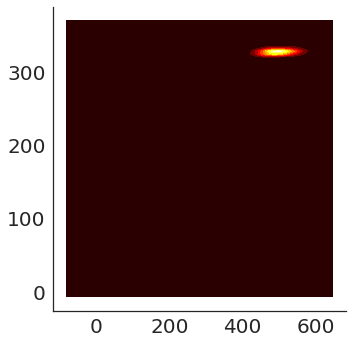

In [129]:
g = sns.jointplot(data[:,0],data[:,1],kind='kde',cmap=plt.cm.hot)

g.ax_marg_x.remove()
g.ax_marg_y.remove()

Text(0.5, 1.0, 'Trajectories')

/home/shayok/anaconda3/envs/python35/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Universalis ADF Cd Std'] not found. Falling back to DejaVu Sans.


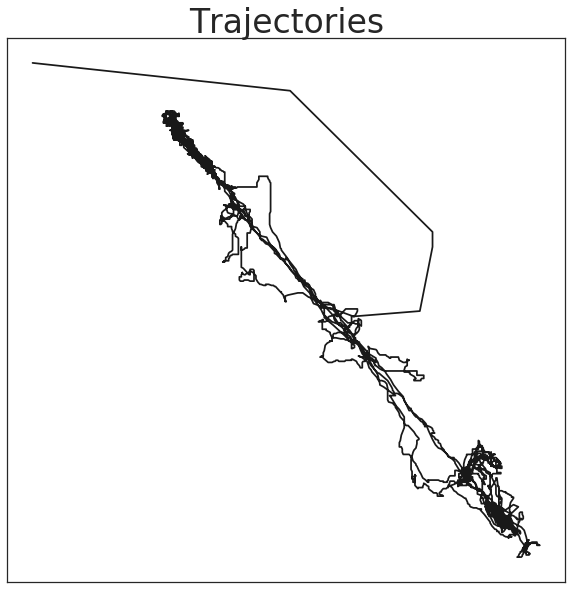

In [94]:
plt.plot(data[:,0]
         , data[:,1]
        )
plt.gca().invert_yaxis()
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.title('Trajectories')